In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/social-media-test/social_media_test.csv


In [3]:
df = pd.read_csv('/kaggle/input/social-media-test/social_media_test.csv')

In [11]:
df.head()

,Unnamed: 0,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,sim_name_username,len_desc,extern_url,private,num_posts,num_followers,num_following
0,0,0,1,0.33,1,0.33,Full match,30,0,1,35,488.0,604
1,1,0,1,0.00,5,0.00,Partial match,64,0,1,3,35.0,6
2,2,0,1,0.00,2,0.00,Partial match,82,0,1,319,328.0,668
3,3,0,1,0.00,1,0.00,No match,143,0,1,273,14890.0,7369
4,4,0,1,0.50,1,0.00,No match,76,0,1,6,225.0,356


In [7]:
df.loc[df['profile_pic'] == 'Yes', 'profile_pic'] = 1
df.loc[df['profile_pic'] == 'No', 'profile_pic'] = 0

In [9]:
df.loc[df['private'] == 'Yes', 'private'] = 1
df.loc[df['private'] == 'No', 'private'] = 0

In [10]:
df.loc[df['extern_url'] == 'Yes', 'extern_url'] = 1
df.loc[df['extern_url'] == 'No', 'extern_url'] = 0

In [14]:
df['sim_name_username'].value_counts()

sim_name_username
No match         63
Partial match    57
Name: count, dtype: int64

In [13]:
df.loc[df['sim_name_username'] == 'Full match', 'sim_name_username'] = 'Partial match'

In [16]:
df.loc[df['sim_name_username'] == 'No match', 'sim_name_username'] = 0

In [19]:
df.head()

,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,sim_name_username,len_desc,extern_url,private,num_posts,num_followers,num_following
0,0,1,0.33,1,0.33,1,30,0,1,35,488.0,604
1,0,1,0.00,5,0.00,1,64,0,1,3,35.0,6
2,0,1,0.00,2,0.00,1,82,0,1,319,328.0,668
3,0,1,0.00,1,0.00,0,143,0,1,273,14890.0,7369
4,0,1,0.50,1,0.00,0,76,0,1,6,225.0,356


In [18]:
df = df.drop('Unnamed: 0', axis = 1)

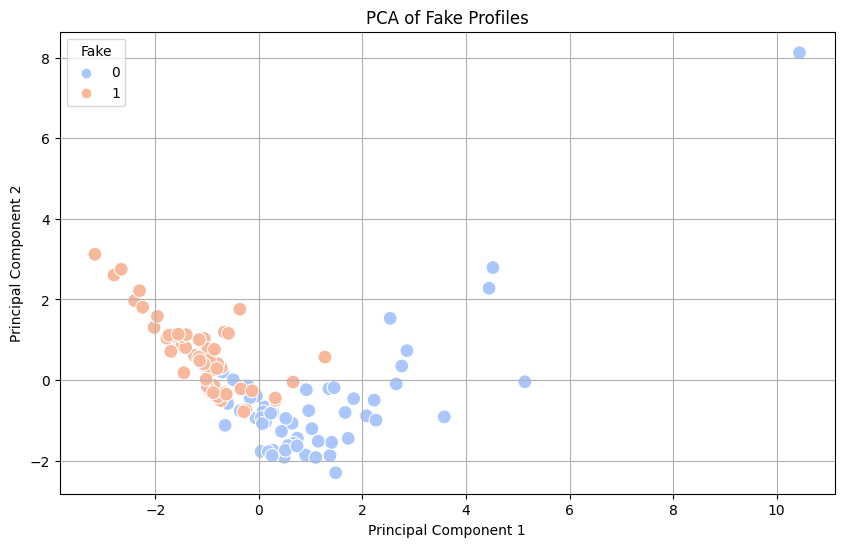

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
columns_for_pca = [
    'profile_pic', 'ratio_numlen_username', 'len_fullname',
    'ratio_numlen_fullname', 'sim_name_username', 'len_desc',
    'extern_url', 'private', 'num_posts', 'num_followers', 'num_following'
]

# Standardizing the data
df_std = (df[columns_for_pca] - df[columns_for_pca].mean()) / df[columns_for_pca].std()

# Performing PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_std)

# Creating a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, df[['fake']]], axis=1)

# Plotting the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC1', y='PC2', hue='fake', data=pca_df, palette='coolwarm', s=100
)
plt.title('PCA of Fake Profiles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Fake')
plt.grid(True)
plt.show()

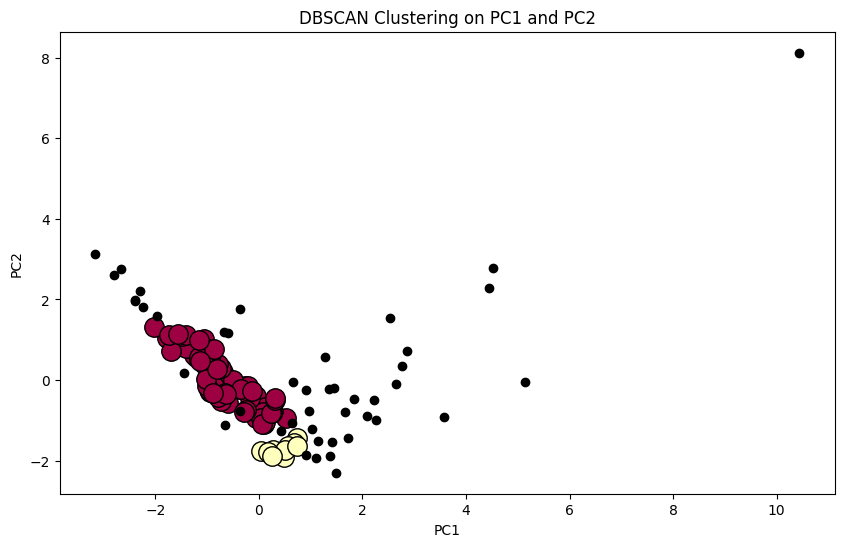

In [54]:
from sklearn.cluster import DBSCAN

X = pca_df[['PC1', 'PC2']].values
dbscan = DBSCAN(eps=0.35, min_samples=7)

pca_df['Cluster'] = dbscan.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(pca_df['Cluster'])

# Create a color palette for the clusters
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1]
    
    class_member_mask = (pca_df['Cluster'] == k)
    
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14 if k != -1 else 6)

plt.title('DBSCAN Clustering on PC1 and PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()